# Scientific Computing: Assignment Set 3
_Boyan Mihaylov (15067602)_

## 0. Imports / Preliminaries

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse.linalg as spla
import time

from importlib import reload

The module `solvers.py` contains functions for PDE solving and the module `vis_tools.py` contains visualisation functions.

In [2]:
import solvers as sv
import vis_tools as vis

## 1. Eigenmodes of Vibrating Membranes

The waves occuring in the transverse vibration of tensioned elastic membranes, such as drums, are known to resonate in specific patterns determined by the eigenmodes and eigenfrequencies of the system. These characteristics are heavily dependent on the shape of the membrane's boundary. The first experiment explores this dependence by formulating a discrete model for solving the eigenvalue problem for membranes with different boundary geometries.

The vibrations of the membrane are governed by the wave equation:

$$
\frac{\partial^2u}{\partial t^2}=c^2\nabla^2{u},\tag{1}
$$

where $u$ is the amplitude of the transverse wave.

### 1.1. Discretisation of the System

The procedure to transform this equation into an eigenvalue problem involves a separation of variables, requiring the decomposition of the amplitude into a purely space-dependent and a purely time-dependent term:

$$
u(x,y,t)=v(x,y)T(t).
$$

This asserted formulation can be substituted into (1), yielding the equation

$$
\frac{1}{c^2T(t)}\frac{\partial^2T(t)}{\delta{t}^2}=\frac{1}{v(x,y)}\nabla^2{v(x,y)}.\tag{2}
$$

With the $t$-dependent and the $(x,y)$-dependent variables separated in the two sides of the equation, it can be stated that the common value of the two sides is a constant, $K$. Expressing the left side through $K$ yields

$$
\frac{\partial^2T(t)}{\delta{t}^2}=Kc^2T(t),
$$

which has an oscillating solution for $K < 0$, dependent on the eigenfrequency $\lambda$:

$$
T(t) = A\cos(c\lambda t) + B\sin(c\lambda t).
$$

$\lambda$ is positive and real under $K\in\mathbb{R}$, as it obeys the relationship $\lambda^2=-K$. The solutions for $K=0$ and $K<0$ exhibit a static behaviour under fixed boundary conditions and an exponential growth/decay, respectively.

The expression relevant for the eigenvalue problem is the right side of (2), expressed through $K$:

$$
\nabla^2{v(x,y)}=Kv(x,y)\tag{3},
$$

as it can be written in the form $\bm{M}\bm{v}=K\bm{v}$, where $\bm{v}$ is the vector of amplitudes $v(x,y)$, $K$ is a scalar constant and $\bm{M}$ is derived from the finite difference approximation of the Laplacian term:

$$
\nabla^2{v(x,y)}\approx \frac{1}{\delta{x}^2}\left[v(x+\delta{x}, y)+v(x-\delta{x},y)+v(x,y+\delta{x})+v(x,y-\delta{x})-4v(x,y)\right],
$$

assuming that $\delta{x}\equiv\delta{y}$. Representing the system through a discrete rectangular lattice of size $(N_x + 1) \times (N_y + 1)$, the matrix $\bm{M}$ is constructed from the neighbour coefficients in the finite difference scheme for the amplitude at each lattice point, $v_i$. With the total number of lattice sites written as $N_T=(N_x + 1) (N_y + 1)$, the index $i=\{0,\ldots,N_T-1\}$ follows the flattened row-wise order of the lattice elements. In a rectangular lattice, this means $i=kN_x + j$, with $j=\{0,\ldots, N_x\}, k=\{0,\ldots,N_y\}$. Respectively, the top, bottom, left and right neighbours of a lattice site can be addressed with the indices $n_1$, $n_2$, $n_3$ and $n_4$, offset from the current index depending on the boundary shape of the system. In a rectangular lattice, for each $i=kN_x + j$,

$$
n_1=(k+1)N_x + j,\\
n_2=(k-1)N_x+j,\\
n_3=kN_x+j+1\\
n_4=q,kN_x + j-1,
$$

By factoring out $1/\delta{x}^2$, Eq. (3) can be expressed as a system of linear equations:

$$
\frac{1}{\delta{x}^2}(v_{n_1}+v_{n_2}+v_{n_3}+v_{n_4}-4v_{i})=Kv_{i},
$$

which represents the row-wise operations of the eigenvalue problem $\frac{1}{\delta{x}^2}\bm{A}\bm{v}=K\bm{v}$. The left side of the equation indicates which coefficients $a_{i,q}$, $q=\{0,\ldots,N_T\}$, contained in the rows of the matrix $\bm{A}\in \mathbb{R}^{N_T \times N_T}$ to set to a non-zero value:

$$
a_{i,q}=\begin{cases}-4 & \textrm{if} \quad q=i\\ 1 & \textrm{if} \quad q \in \{n_1, n_2, n_3, n_4\} \\ 0 & \textrm{otherwise}.\end{cases}
$$

As the boundary is considered fixed, a Dirichlet boundary condition imposes a constant $v(x,y)=0$ at the edges. To prevent the boundaries from updating, all neighbour coefficients referring to boundary sites are set to zero. Conversely, each row $a_{b}$ in $\bm{A}$ relating to a boundary site contains at most one non-zero coefficient, referring to itself: $a_{b,b}=-4$

The following procedure demonstrates the construction of $\bm{M}$ from an input size $N_x\times N_y$ and visualises the indexing of the lattice as well as the resulting matrix of coefficients. In the example, the dimensions are set to $N_x=N_y=4$.

In [157]:
reload(vis)
reload(sv)

<module 'solvers' from 'd:\\Msc Computational Science\\S02P01\\Scientific Computing\\GitHub\\scented-candles\\Assignment Set 3\\solvers.py'>

[[-4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0. -4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -4.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -4.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -4.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -4.  0.  0.  0.  

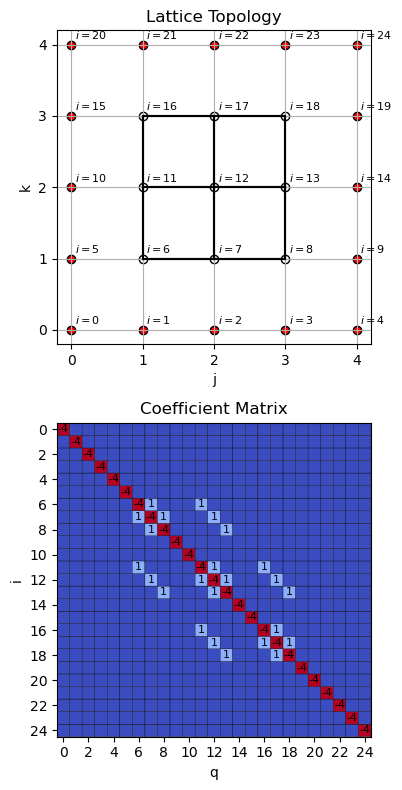

In [158]:
size_x = 5
size_y = 5

coeffs_matrix, lattice_coords = sv.construct_coeff_matrix(size_x, size_y)

print(coeffs_matrix)

# vis.plot_lattice_topology(size_x, size_y)
# vis.plot_lattice_topo_from_coeff(coeffs_matrix, lattice_coords)
# vis.plot_coeff_matrix(coeffs_matrix)
vis.plot_lattice_2D(coeffs_matrix, lattice_coords)

In the first plot above, the fixed boundary sites with $v(x,y)=0$ are shown as red dots. The thick continuous lines represent a two-way relationship in the update functions of two neighbours, whereas the lack of connections indicate that the lattice site only takes into consideration its own state in the update function. The second plot illustrates the matrix of coefficients, with the indices along each axis corresponding to $i$ in the first plot.

It is evident that the boundary sites are redundant to the coefficient matrix, as they neither become updated, nor contribute to their interior neighbours. For this reason, $\bm{A}$ can be further reduced to a matrix of size $N_R \times N_R$, $N_R = (N_x - 1)(N_y - 1)$, which only contains the coefficients of the interior sites. The following plots illustrate the resulting system.

[[-4.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  1. -4.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0. -4.  1.  0.  1.  0.  0.]
 [ 0.  1.  0.  1. -4.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  1. -4.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0. -4.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  1. -4.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  1. -4.]]


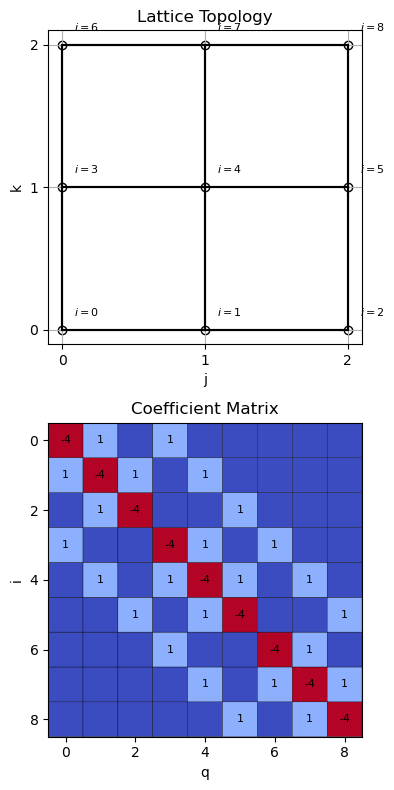

In [159]:
size_x = 5
size_y = 5

coeffs_matrix, lattice_coords = sv.construct_coeff_matrix_alt(size_x, size_y)

print(coeffs_matrix)

# vis.plot_lattice_topology(size_x, size_y)
# vis.plot_lattice_topo_from_coeff(coeffs_matrix, lattice_coords)
# vis.plot_coeff_matrix(coeffs_matrix)
vis.plot_lattice_2D(coeffs_matrix, lattice_coords)

The lattice can be initiated with a rectangular or a circular boundary. In the latter case, first a rectangular lattice with size $L_x\times L_y$ is created and a circular region with a radius $R=\min{\{L_x, L_y\}}/2$ is inscribed in the centre of the lattice. The lattice indices and coordinates are then reduced to only the sites which fall within this region and the boundary sites are defined as those sites inside the circle which border to at least one site not included in the circle.

The following plots illustrate the reduced topology (excluding boundary sites) of a circle inscribed on a lattice with $N=10$ subdivisions.

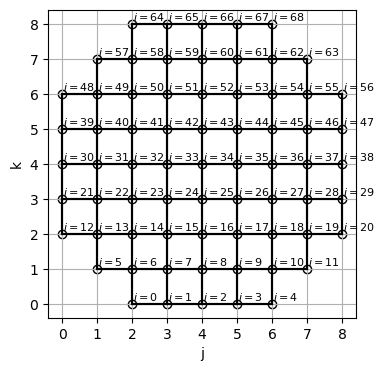

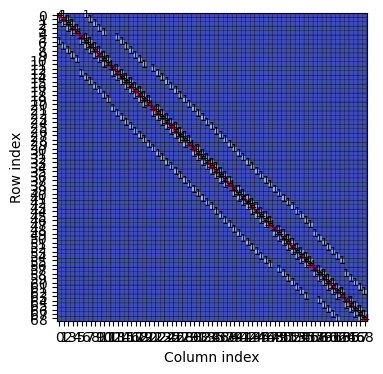

In [134]:
coeffs_matrix_circle, lattice_coords_circle = sv.construct_coeff_matrix_alt(11, 11, 'circle')

vis.plot_lattice_topo_from_coeff(coeffs_matrix_circle, lattice_coords_circle)
vis.plot_coeff_matrix(coeffs_matrix_circle)

### 1.2. Comparing Methods

Three different boundary conditions are selected to exemplify the solution of the eigenvalue problem $\frac{1}{\delta{x}^2}\bm{A}\bm{v}=K\bm{v}$ under three different boundary conditions: a square, a $1:2$-ratio rectangle and a circle. To determine $\delta{x}$, a reference size measure $L$ is defined, such that $\delta{x}=L/N$, $N=\min{\{N_x, N_y\}}$. The studied boundary shapes thus have comparable sizes:
- the square has a side length $L$;
- the rectangle has side lengths $L$ and $2L$;
- the circle has a diameter $L$.

Four different eigenvalue solving methods are tested and compared in their execution speed: `scipy.linalg.eig`, `scipy.linalg.eigh`, `scipy.sparse.linalg.eigs` and `scipy.sparse.linalg.eigsh`. The first one is a general purpose solver, the second one is suited for real symmetric or Hermitian matrices. The second two are analogous to the first ones but employ sparse matrices, which are generally beneficial for matrices with a large quantity of zero elements, as they only store the nonzero ones and therefore require less storage. To provide appropriate input for these functions, the matrices are pre-converted into diagonal sparse matrices using the funcion `scipy.sparse.dia_matrix`. The difference in performance becomes visible with larger system sizes, therefore the subdivision is increased to $N=40$.

The running times for each function refer to an execution on a 2.00 GHz 13th Gen Intel(R) Core(TM) i9-13900 personal computer.

In [226]:
reload(sv)

<module 'solvers' from 'd:\\Msc Computational Science\\S02P01\\Scientific Computing\\GitHub\\scented-candles\\Assignment Set 3\\solvers.py'>

In [227]:
L = 1
N = 40
dx = 1 / N

setups = dict()
setups['names'] = ['square', 'rectangle', 'circle']
setups['shape'] = ['rect', 'rect', 'circle']
setups['N_y'] = [N, 2*N, N]
factor = L/dx**2
eigval_funcs = [la.eig, la.eigh, spla.eigs, spla.eigsh]

# DataFrame for storing the results
results_method = pd.DataFrame(columns=[''] + setups['names'])

# Loop over the different eigval functions
for func in eigval_funcs:

    if func in [spla.eigs, spla.eigsh]:
        sparse = True
    else:
        sparse = False
    
    results_row = pd.DataFrame(dict(zip([''] + setups['names'],
                                        [[func.__name__ + str(" time"), func.__name__ + str(" $\lambda_{min}$")],
                                         [None, None],[None, None],[None, None]])))
    # Loop over the different setups
    for name, shape, N_y in zip(setups['names'], setups['shape'], setups['N_y']):
        coeffs_matrix, _ = sv.construct_coeff_matrix_alt(N, N_y, shape, sparse)
        start_time = time.time()
        eigvals, eigvecs = sv.solve_eigval_problem(coeffs_matrix, factor, func)
        end_time = time.time()
        time_elapsed = end_time - start_time
        results_row[name].iloc[0] = time_elapsed
        results_row[name].iloc[1] = float(eigvals[np.argsort(np.abs(eigvals))][0])
    
    results_method = pd.concat([results_method, results_row], axis=0)

results_method

C:\Users\mihbo\AppData\Local\Temp\ipykernel_8224\4057602052.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  results_row[name].iloc[1] = float(eigvals[np.argsort(np.abs(eigvals))][0])


,,square,rectangle,circle
0,eig time,0.588761,3.64173,0.413203
1,eig $\lambda_{min}$,-20.753228,-12.906543,-24.284445
0,eigh time,0.477587,1.35175,0.335279
1,eigh $\lambda_{min}$,-20.753228,-12.906543,-24.284445
0,eigs time,0.03783,0.083662,0.018912
1,eigs $\lambda_{min}$,-20.753228,-12.906543,-24.284445
0,eigsh time,0.029762,0.060178,0.017861
1,eigsh $\lambda_{min}$,-20.753228,-12.906543,-24.284445


In [228]:
results_method.to_latex('results_eigval_method.tex', index=False)

The results show a clear reduction in computation time for all boundary shapes when a more specialised method (`scipy.linalg.eigh`, `scipy.sparse.linalg.eigsh`) is used instead of its general purpose counterpart. This is to be expected, since the provided matrices are real symmetric and can benefit from the functionality of these methods. A difference of an entire order is visible when switching from a dense-matrix method to a sparse-matrix method. This is an obvious result from the reduction of computations achieved by sparse matrix systems. By retrieving the smallest eigenvalue calculated by each method it can be shown there is no significant difference in the computed results for this specific case.

### 1.3. Finding the Eigenmodes

Having established the superiority of specialised sparse-matrix methods in solving the eigenvalue problem efficiently, the eigenspectrum of the three systems is examined in more detail, using the method `scipy.sparse.linalg.eigsh`. The method is set up to return the 6 smallest eigenvalues (eigenfrequencies) and their corresponding eigenvectors (eigenmodes). The modes are visualised as colour values in the membrane domain, with an indication of their corresponding frequency $K$.

In [229]:
# Eigenvalue problem solver
eigval_func = spla.eigsh

eigvals_shapes = []
eigvecs_shapes = []
lattice_coords_shapes = []

# Loop over the different setups
for name, shape, N_y in zip(setups['names'], setups['shape'], setups['N_y']):
    coeffs_matrix, lattice_coords = sv.construct_coeff_matrix_alt(N, N_y, shape, True)
    eigvals, eigvecs = sv.solve_eigval_problem(coeffs_matrix, factor, eigval_func)
    lattice_coords_shapes.append(lattice_coords)
    eigvals_shapes.append(eigvals[-6:].astype(float))
    eigvecs_shapes.append(eigvecs[-6:])

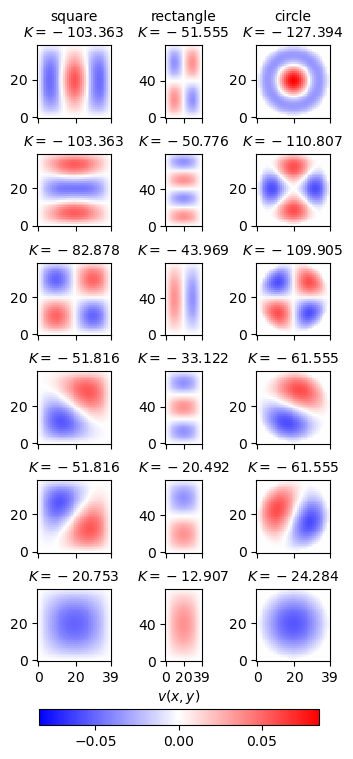

In [274]:
vis.plot_eigmodes_spectrum(eigvecs_shapes, eigvals_shapes, lattice_coords_shapes, setups['names'])

### 1.4. Influence of $L$ and $N$

Beside the boundary shape, there are two numerical factors determining the setup of the system. One is the size measure $L$ and the other one is the number of subdivisions $N$ per length $L$. As they conjointly determine the factor of multiplication for $\bm{A}$, $\frac{1}{\delta{x}^2}$, their influence is to be examined separately, by fixing either parameter and varying the other. The changes in the eigenvalue spectrum are then observed, in particular the 6 smallest eigenvalues. Beside its influence on $\delta{x}$, $N$ also defines the size of the coefficient matrix, the number of eigenvalues and the granularity of the lattice domain. It is therefore relevant to observe how the resulting eigenvalue range (smallest vs. largest eigenvalue) changes with varying $N$.

The experimental setup for this study uses the same boundary shapes as before but alters their size parameters. For the study of $L$, the vector of eigenvalues is saved for each incremental increase of $L$ from $0.5$ to $10$, with $N=8$ (resulting in $6\times 6$ non-boundary sites in the square case). The stored vectors are subsequently visualised in a three-dimensional surface plot. For the study of $N$, $L$ is kept at $1$ and $N$ is increased from $5$ to $100$. The largest and the smallest eigenvalues are saved at each step and finally plotted.

In [231]:
# Simulation setup
Ls = np.linspace(0.5, 1000, 2000)
N = 8
setups['N_y'] = [N, 2*N, N]
eigval_func = spla.eigsh

# Variables for storing simulation results
result_setups = pd.DataFrame(columns=['Boundary', 'L'])
result_eigvals = np.empty((len(Ls), len(setups['names']), 6))

# Loop over the different setups
for i, L in enumerate(Ls):
    dx = L / N
    factor = 1/dx**2
    for j, (name, shape, N_y) in enumerate(zip(setups['names'], setups['shape'], setups['N_y'])):
        coeffs_matrix, _ = sv.construct_coeff_matrix_alt(N, N_y, shape, True)
        eigvals, _ = sv.solve_eigval_problem(coeffs_matrix, factor, eigval_func)
        result_setups = pd.concat([result_setups, pd.DataFrame({'Boundary': [name], 'L': [L]})], axis=0)
        result_eigvals[i, j] = eigvals

result_eigvals = result_eigvals.reshape(-1, 6)

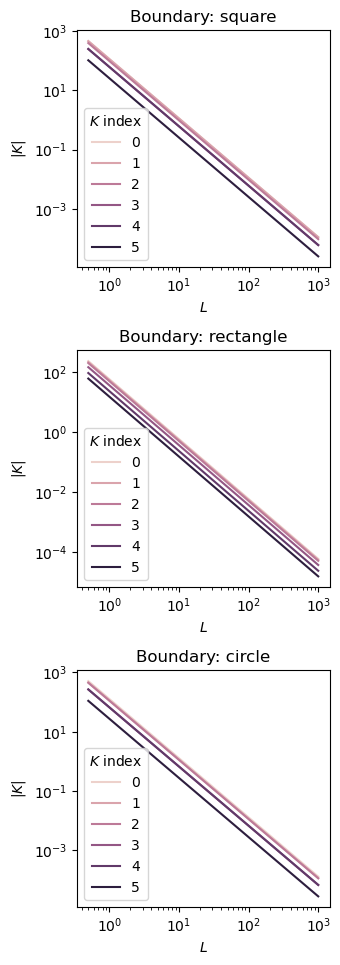

In [232]:
vis.plot_eigvals_Ls(result_setups, result_eigvals)

The straight lines in the log-log plots of $L$ vs. $|K|$ clearly indicate an exponential decrease in the eigenvalues with increasing $L$.

In [272]:
# Simulation setup
L = 1
Ns = np.arange(5, 105, 5)

# Variables for storing simulation results
result_setups = pd.DataFrame(columns=['Boundary', 'N'])
result_eigvals = np.empty((len(Ns), len(setups['names']), 2))

# Loop over the different setups
for i, N in enumerate(Ns):
    dx = L / N
    factor = 1/dx**2
    setups['N_y'] = [N, 2*N, N]
    for j, (name, shape, N_y) in enumerate(zip(setups['names'], setups['shape'], setups['N_y'])):
        coeffs_matrix, _ = sv.construct_coeff_matrix_alt(N, N_y, shape, True)
        eigvals, _ = sv.solve_eigval_problem(coeffs_matrix, factor, eigval_func, both_ends=True)
        result_setups = pd.concat([result_setups, pd.DataFrame({'Boundary': [name], 'N': [N]})], axis=0)
        result_eigvals[i, j] = [np.min(eigvals), np.max(eigvals)]

result_eigvals = result_eigvals.reshape(-1, 2)

In [270]:
reload(vis)

<module 'vis_tools' from 'd:\\Msc Computational Science\\S02P01\\Scientific Computing\\GitHub\\scented-candles\\Assignment Set 3\\vis_tools.py'>

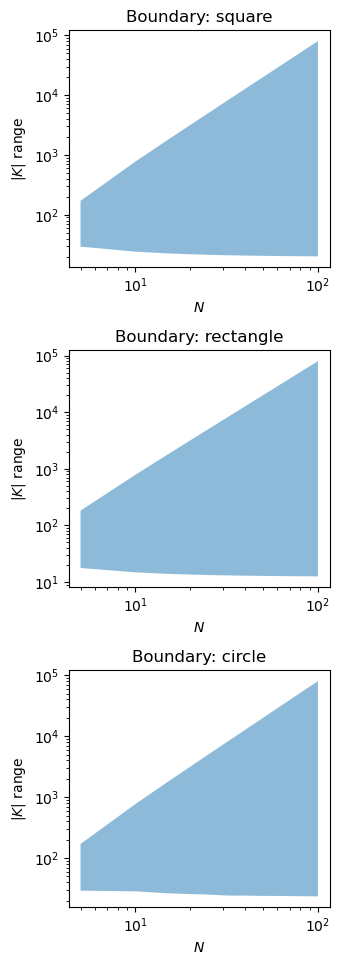

In [271]:
vis.plot_eigvals_Ns(result_setups, result_eigvals)

Observing the upper bounds of the eigenspectrum, the plots indicate a seemingly exponential increase in the largest $|K|$ values with increasing $N$ for all boundary shapes. Contrarily, the lower bounds of the eigenspectrum appear to converge to an asymptotic value with increasing $N$.

## 2. Direct Method for Solving the Diffusion Equation

A matrix-based approach can also be applied as a direct method for solving the diffusion equation

$$
\frac{\partial c}{\partial t}=D\nabla^2c.\tag{2}
$$

on a two-dimensional domain analogous to the one for computing the wave eigenspectrum. The variable $c(t,x,y)$ represents the local concentration over time $t$ and space $(x,y)$. In many applications, it suffices to find a solution for the steady state of the system, i.e. when the concentrations are no longer dependent on time. The system is then solely governed by the Laplace equation $\nabla^2c=0$, which can be discretised using the following finite difference scheme:

$$
c_{j+1,k}+c_{j-1,k}+c_{j,k+1}+c_{j,k-1}-4c_{i,j}=0,
$$

with $j=\{1,\ldots, N_x-1\}, k=\{1,\ldots,N_y-1\}$. This equation can also be represented as coefficients in a matrix $\bm{M}=\frac{1}{4}\bm{A}$ ($\bm{A}, \bm{M}\in \mathbb{R}^{N_R\times N_R}$), using the exact same procedure as with the two-dimensional wave equation.

A special case arises when one or more of the lattice site neighbours belong to a fixed boundary condition. If $c_{b}=\textrm{const}$, $b \in \{n_1, n_2, n_3, n_4\}$, the boundary condition value can be shifted to the right side of the equation, yielding

$$
\sum_{n \, \textrm{not in boundary}}{c_n}=-\sum_{b}c_b.
$$

This way the boundary condition can be integrated in the right-side vector $\bm{b}$, forming the linear system $\bm{M}\bm{c}=\bm{b}$. This system can then be solved using the `scipy.linalg.solve` method.

The previous procedure for constructing the coefficient matrix is therefore extended to also return $\bm{b}$ accounting for the boundary condition wherever relevant.